# 라이브러리 import

In [2]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

# 사진준비
- ```images/``` 경로에 있는 사진들을 ```glob```로 가져오기
- ```cv2.imread```를 사용해서 이미지를 읽어서 ```img_origs``` list에 저장

In [59]:
img_paths = glob('images/0*.jpg')  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_paths.sort()
img_paths

['images/01_my_image.jpg',
 'images/02_image3.jpg',
 'images/03_doong.jpg',
 'images/04_jjun.jpg']

In [60]:
img_origs = []

for path in img_paths : 
    img_origs.append(cv2.imread(path))

img_origs[0].shape

(2736, 3648, 3)

# Semantic Segmentation 다루기
- DeepLab이라는 Segmentation 모델을 만들고 모델에 이미지를 입력
- DeepLabModel 클래스

In [61]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [62]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [63]:
img_orig = img_origs[2]

In [64]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(3024, 4032, 3) (384, 513, 3) 12


In [65]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

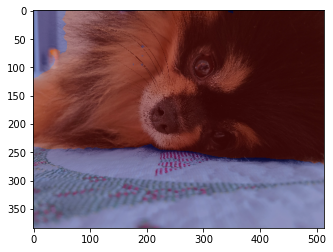

In [66]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 12, 12, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

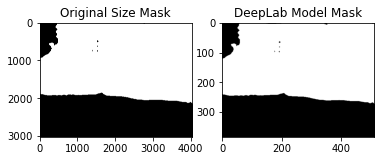

In [67]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

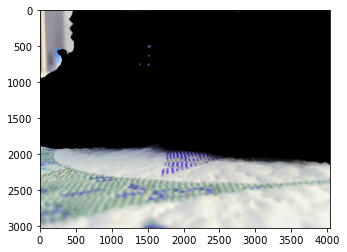

In [68]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

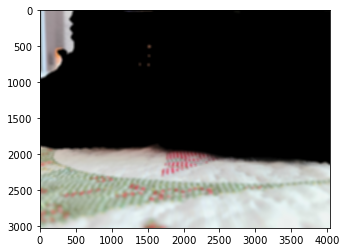

In [69]:
img_bg_blur = cv2.blur(img_bg, (40, 40))  # 원래는 (13, 13), 이미지의 사이즈가 워낙 커서 값을 늘림
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

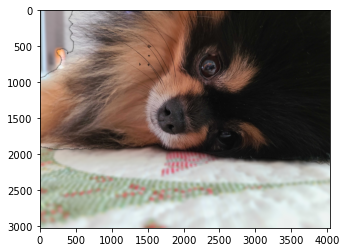

In [70]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [71]:
def segmentation(img_orig, label):
    img_resized, seg_map = MODEL.run(img_orig)
    LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
    
    label_idx = LABEL_NAMES.index(label)
    
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == label_idx, label_idx, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    
    plt.figure(figsize=(15, 30))
    plt.subplot(1,2,1)
    plt.title('segmentation img')
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
#     plt.show()
    

    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    
    img_bg_blur = cv2.blur(img_bg, (40, 40))  # 원래는 (13, 13), 이미지의 사이즈가 워낙 커서 값을 늘림
    
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    plt.subplot(1,2,2)
    plt.title('blurred img')
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    

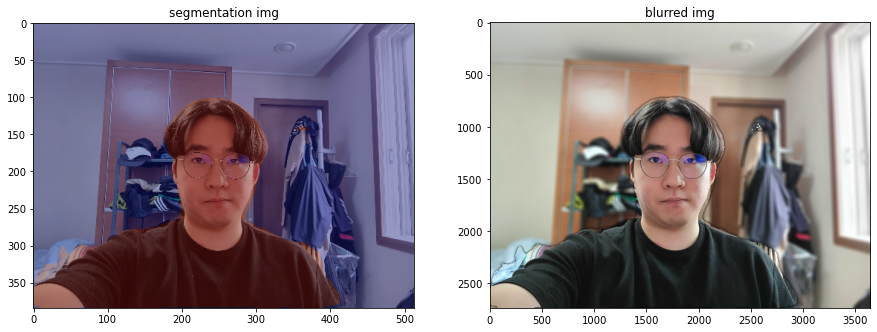

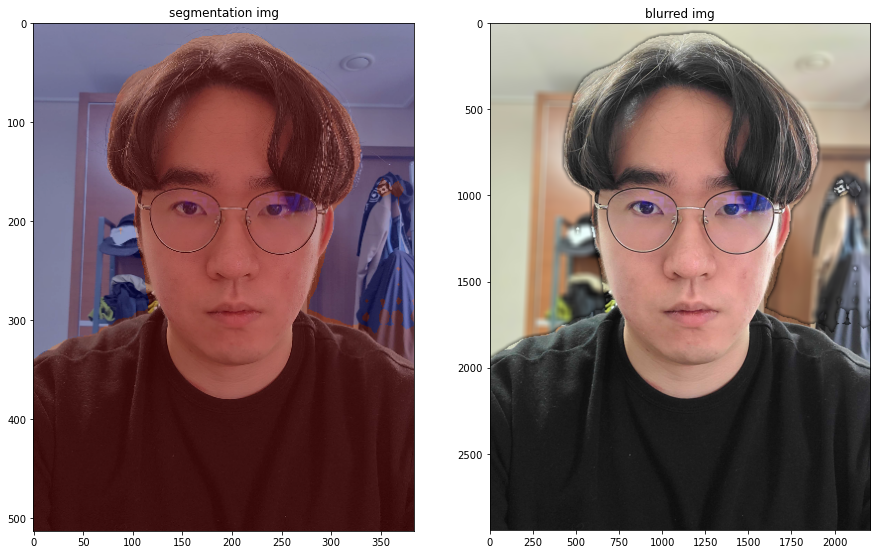

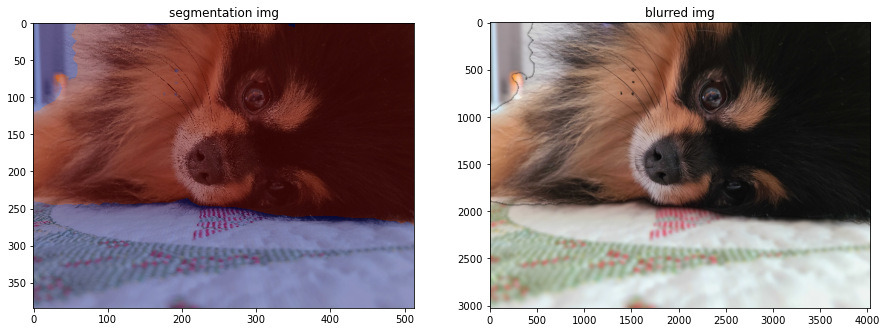

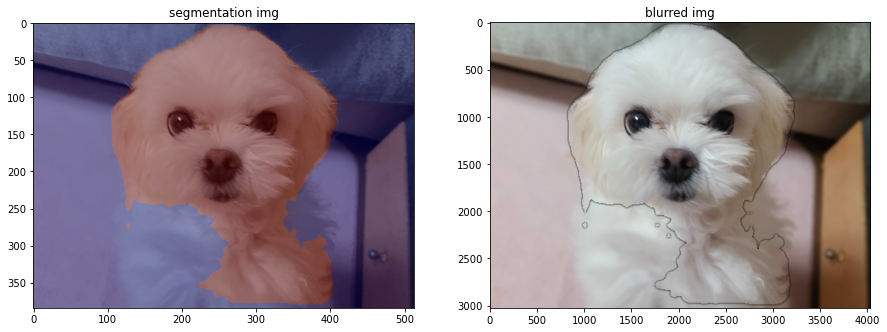

In [72]:
lst = ['person', 'person', 'dog', 'dog']
for i in range(len(img_origs)) :
    segmentation(img_origs[i], lst[i])

# 배경을 바꿔봅시다
- 귀여운 강아지 사진
    ![03_doong](https://user-images.githubusercontent.com/48716219/93452193-188fe600-f913-11ea-8fde-4a2dd9755c03.jpg)  
      
<br>  
<br>  
- 배경 두가지
    ![back](https://user-images.githubusercontent.com/48716219/93469002-ce1a6380-f92a-11ea-8c43-d726953444ae.jpeg)
    ![back2](https://user-images.githubusercontent.com/48716219/93469015-d5da0800-f92a-11ea-9ddd-97b420d10b62.jpg)
    
<br>  
<br>  
- 소인국에 드러누워있는 강아지와 불상 대신에 누워있는 강아지를 만들어본다.

## 강아지 사진 읽어오기
- 배경의 사이즈도 resize를 해주기 위해서 강아지 사진의 사이즈를 저장해둔다.

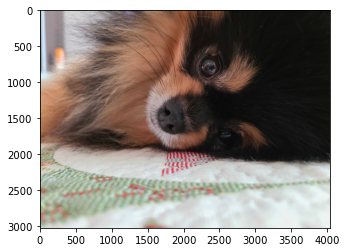

(3024, 4032, 3)


In [17]:
cute_ = cv2.cvtColor(cv2.imread('images/03_doong.jpg'), cv2.COLOR_BGR2RGB)
cute = cv2.imread('images/03_doong.jpg')
plt.imshow(cute_)
plt.show()
h, w, _ = cute.shape
print(cute.shape)

## 마스크 리턴 함수
- 배경마스크, content마스크, 그리고 content를 리턴해주는 함수를 작성한다
- 입력인자는 이미지의 경로

In [39]:
def ret_mask(img_path) :
    # 이미지 읽기
    img_gbr = cv2.imread(img_path)
    img_resized, seg_map = MODEL.run(img_gbr)
    
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == seg_map.max(), seg_map.max(), 0)
    img_mask = seg_map * (255/seg_map.max())
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
#     img_show = cv2.addWeighted(img_show, 0.6)
    
    img_mask_up = cv2.resize(img_mask, img_gbr.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    
    img_content_mask = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    
    content = cv2.cvtColor(cv2.bitwise_and(cute, img_mask_color), cv2.COLOR_BGR2RGB)
    
    
    
    return img_bg_mask, img_mask_color, content

### 커여운 강아지

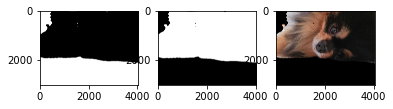

In [40]:
cute_bg_mask, cute_content_mask, cute_content = ret_mask('images/03_doong.jpg')
plt.subplot(1,3,1)
plt.imshow(cute_bg_mask)
plt.subplot(1,3,2)
plt.imshow(cute_content_mask)
plt.subplot(1,3,3)
plt.imshow(cute_content)
plt.show()

###  배경

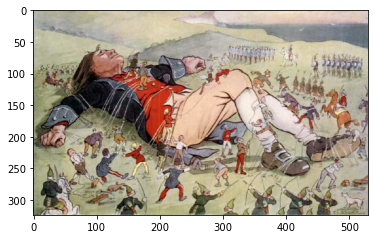

(324, 530, 3)


In [45]:
back1 = cv2.cvtColor(cv2.imread('images/back.jpeg'), cv2.COLOR_BGR2RGB)
plt.imshow(back1)
plt.show()
print(back1.shape)

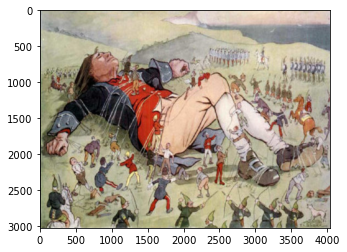

In [46]:
back1 = cv2.resize(back1, (w, h))
plt.imshow(back1)
plt.show()

In [47]:
np.unique(cute_content_mask)

array([  0, 255], dtype=uint8)

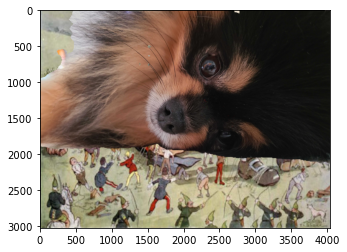

In [48]:
result1 = cv2.bitwise_and(back1, cute_content_mask)
result1 = np.where(result1 == cute_content_mask, back1, cute_content)
plt.imshow(result1)
plt.show()

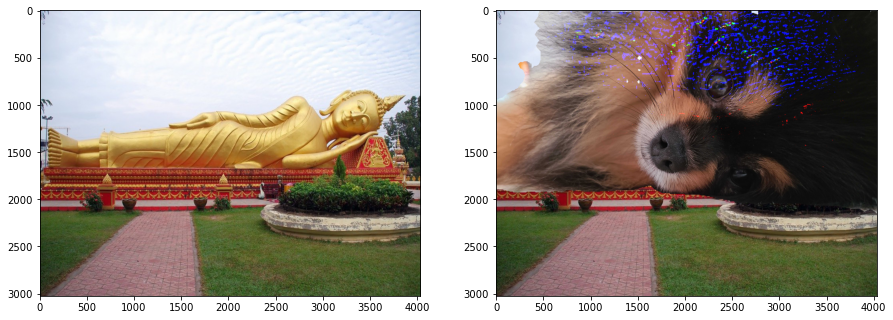

In [58]:
back2 = cv2.cvtColor(cv2.imread('images/back2.jpg'), cv2.COLOR_BGR2RGB)
back2 = cv2.flip(cv2.resize(back2, (w, h)), 1)
result2 = cv2.bitwise_and(back2, cute_content_mask)
result2 = np.where(result2 == cute_content_mask, back2, cute_content)

plt.figure(figsize=(15, 30))
plt.subplot(1,2,1)
plt.imshow(back2)
plt.subplot(1,2,2)
plt.imshow(result2)
plt.show()

# 문제점

- 배경을 바꿀때는 티가 나지 않지만 아웃포커싱을 직접 구현할 경우 다음과 같은 문제들이 발생했다.
    ![image](https://user-images.githubusercontent.com/48716219/93469901-19814180-f92c-11ea-8aea-977d8f60b4bb.png)
- 피사체(인물 혹은 동물)를 제외한 배경을 blur처리를 하고 피사체를 다시 위에 붙이는 작업을 수행했었다. 하지만 blur처리를 하는 과정에서 피사체가 빠진 자리를 검은색으로 채우고, 그 뒤로 blur 필터를 입히게 되어서 검은색도 경계선이 모호해지면서 피사체를 붙인 후에도 사진 주변에 검은 테두리가 보이게 되었다.
- 뿐만 아니라 피사체 주변에 다른 부분또한 피사체로 포함이 되어서 blur처리가 안된 부분도 있고 흰색 강아지(쭌이 입니다)는 피사체를 제대로 인식하지 못했다.
    ![image](https://user-images.githubusercontent.com/48716219/93470980-b2648c80-f92d-11ea-92b6-7269895330ac.png)


# 해결 방법
1. 하드웨어적인 해결
    - 가장 간단한 방법이다. 3D Depth Camera를 활용한다. 최근에 아이패드에는 RiDAR센서가 포함되어 있고, 최근 갤럭시 시리즈에서 ToF카메라가 후면카메라로 들어가 있는 경우가 있다. 이와 같은 센서 및 카메라는 피사체의 심도를 측정하는 것이 가능하고 AR분야에서도 활용이 가능한 것으로 알고 있다.

# 실패
- 두 사진을 합쳐보자
    - 귀여운 강아지 사진
        ![03_doong](https://user-images.githubusercontent.com/48716219/93452193-188fe600-f913-11ea-8fde-4a2dd9755c03.jpg)
    - 떡 먹는 고릴라
        ![gorilla](https://user-images.githubusercontent.com/48716219/93452250-29d8f280-f913-11ea-9b43-2816a3f49823.jpeg)
- 생각해볼 점
    1. 이미지 사이즈가 많이 다르다
        - 귀여운 강아지는 엄청나게 크고 고릴라 사진의 경우 많이 작다
    2. 두 사진의 생물이 누워있는 방향이 다르다.
        - 방향을 좌우 반전을 시켜야 한다.
    3. 고릴라님을 완전히 지우고 강아지를 붙이도록 해본다.

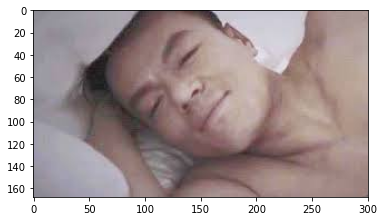

In [129]:
gorilla = cv2.cvtColor(cv2.imread('images/gorilla.jpeg'), cv2.COLOR_BGR2RGB)
plt.imshow(gorilla)
plt.show()

In [133]:
gorilla_flip = cv2.flip(gorilla, 1)
gorilla_flip = cv2.resize(gorilla_flip, (cute.shape[1], cute.shape[0]))
gorilla_flip.shape

(3024, 4032, 3)

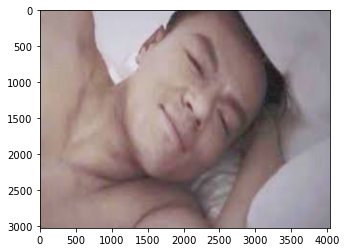

In [134]:
plt.imshow(gorilla_flip)
plt.show()

이 때까진 순조롭게 진행되었지만 지금부터 문제가 생기기 시작한다.  
**'사람'의 얼굴을 일단 지워보려 했다.**

(3024, 4032, 3) (384, 513, 3) 15


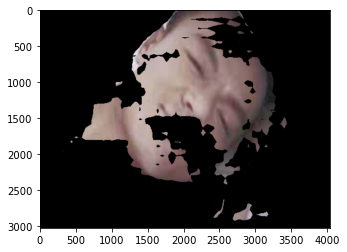

In [135]:
img_resized, seg_map = MODEL.run(gorilla_flip)
print (gorilla_flip.shape, img_resized.shape, seg_map.max())

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
# img_mask_color = np.where()
# img_bg_mask = cv2.bitwise_not(img_mask_color)
# img_bg = np.where(cute == )
gorilla_content = cv2.bitwise_and(gorilla_flip, img_mask_color)
plt.imshow(gorilla_content)
plt.show()

어?

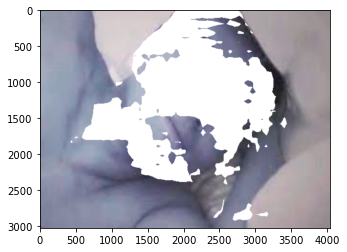

In [141]:
img_concat = np.where(img_mask_color==gorilla_content, gorilla_flip, 255)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세상에나. 실패했다.